In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX



# 1. LOAD AND PREPARE DATA

df = pd.read_csv('/content/AMKR_REV_prediction .csv')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Enhanced numeric conversion
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows where target is missing
if 'Rev_AMKR' in df.columns:
    df = df[df['Rev_AMKR'].notna()].reset_index(drop=True)

print("Dataset Shape:", df.shape)
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Quarters: {len(df)}")
print(f"\nWARNING: Small dataset detected ({len(df)} samples)")
print("Using regularized models and conservative approach...\n")

Dataset Shape: (40, 28)
Date Range: 2015-09-30 00:00:00 to 2025-06-30 00:00:00
Total Quarters: 40

Using regularized models and conservative approach...



CORRELATION ANALYSIS WITH TARGET VARIABLE

Top 15 Variables Correlated with Rev_AMKR:
 2. Materials_Expenses                       :  0.9795
 3. Communications                           :  0.9358
 4. AAPL                                     :  0.8268
 5. Computing                                :  0.8019
 6. Consumer                                 :  0.7871
 7. Operating_Income_AMKR                    :  0.7839
 8. QCOM                                     :  0.7829
 9. WSTS_Billings                            :  0.7798
10. Return on Assets(%)_AMKR                 :  0.7469
11. SOX                                      :  0.7337
12. Gold                                     :  0.5982
13. Equity_Market_Value_AMKR                 :  0.5241
14. Other_Manufacturing_Expenses             :  0.3517
15. Spread_AMKR                              :  0.3112
16. Lead                                     :  0.2723


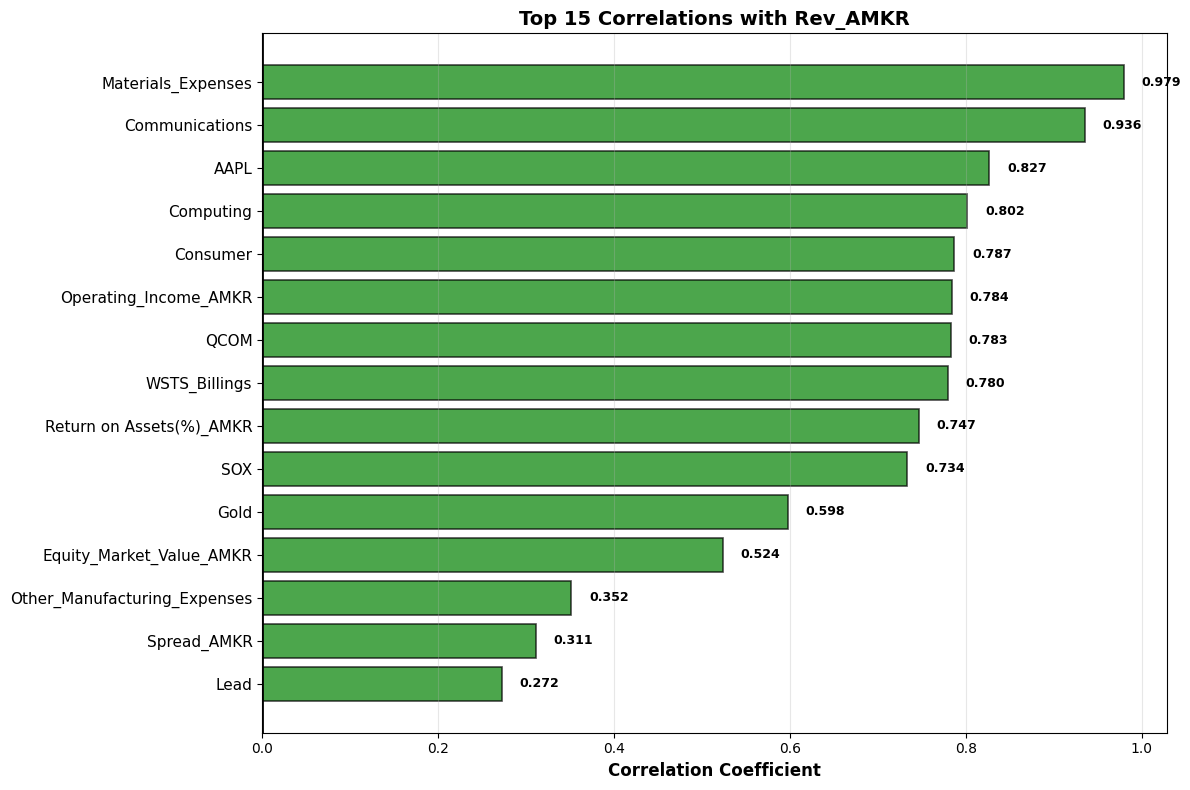


Highly Correlated Variable Pairs (|r| > 0.8):
AAPL                                ↔ Net_Debt_AMKR                       : 0.978
SOX                                 ↔ Net_Debt_AMKR                       : 0.964
SOX                                 ↔ AAPL                                : 0.960
QCOM                                ↔ AAPL                                : 0.955
Communications                      ↔ Materials_Expenses                  : 0.949
SOX                                 ↔ QCOM                                : 0.941
QCOM                                ↔ Net_Debt_AMKR                       : 0.941
WSTS_Billings                       ↔ SOX                                 : 0.919
WSTS_Billings                       ↔ AAPL                                : 0.913
WSTS_Billings                       ↔ Net_Debt_AMKR                       : 0.910
WSTS_Billings                       ↔ Computing                           : 0.903
SOX                                 ↔ Gold         

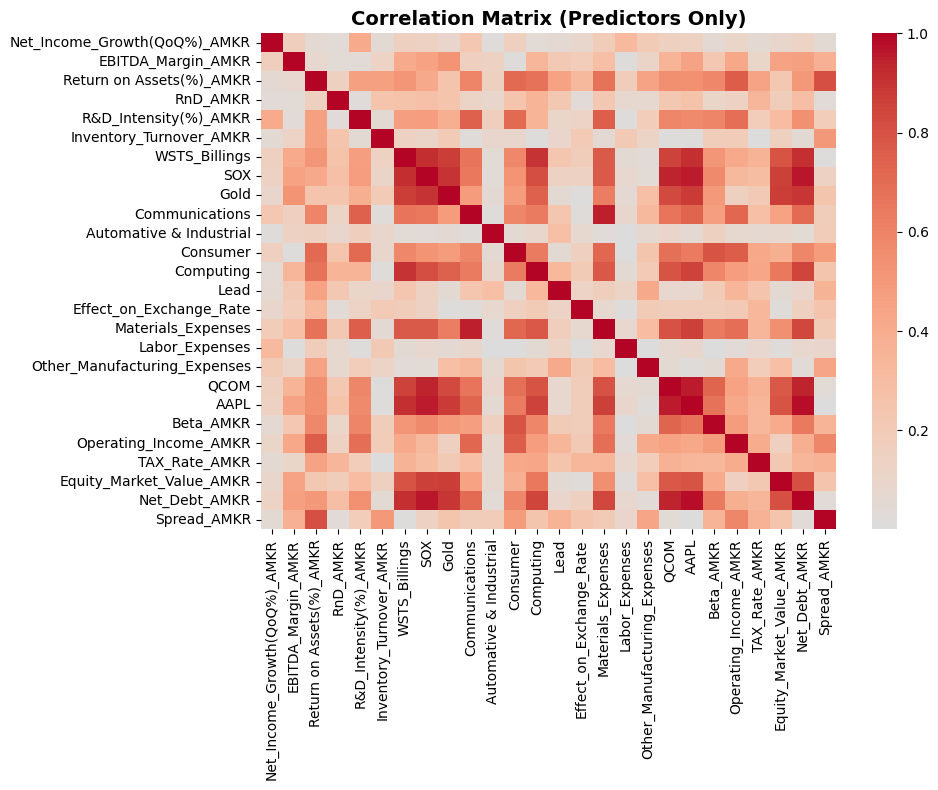

In [ ]:
# 2. CORRELATION ANALYSIS


print("=" * 60)
print("CORRELATION ANALYSIS WITH TARGET VARIABLE")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'Rev_AMKR' in numeric_cols:
    correlations = df[numeric_cols].corr()['Rev_AMKR'].sort_values(ascending=False)

    print("\nTop 15 Variables Correlated with Rev_AMKR:")
    print("=" * 60)
    for i, (var, corr) in enumerate(correlations.items(), 1):
        if var != 'Rev_AMKR':
            print(f"{i:2d}. {var:40s} : {corr:7.4f}")
        if i >= 16:
            break

    # Visualize correlations
    fig_corr1, ax_corr1 = plt.subplots(1, 1, figsize=(12, 8))

    top_corr = correlations[correlations.index != 'Rev_AMKR'][:15]
    colors_pos = ['green' if x > 0 else 'red' for x in top_corr]
    ax_corr1.barh(
        range(len(top_corr)),
        top_corr,
        color=colors_pos,
        alpha=0.7,
        edgecolor='black',
        linewidth=1.2,
    )
    ax_corr1.set_yticks(range(len(top_corr)))
    ax_corr1.set_yticklabels(top_corr.index, fontsize=11)
    ax_corr1.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax_corr1.set_title('Top 15 Correlations with Rev_AMKR', fontsize=14, fontweight='bold')
    ax_corr1.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax_corr1.grid(True, alpha=0.3, axis='x')
    ax_corr1.invert_yaxis()

    for i, v in enumerate(top_corr):
        ax_corr1.text(
            v + 0.02 if v > 0 else v - 0.02,
            i,
            f'{v:.3f}',
            va='center',
            ha='left' if v > 0 else 'right',
            fontsize=9,
            fontweight='bold',
        )

    plt.tight_layout()
    plt.show()

# Compute the full correlation matrix among numeric predictors
corr_matrix = df[numeric_cols].drop(columns=['Rev_AMKR'], errors='ignore').corr().abs()

# Flag highly correlated pairs
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            high_corr_pairs.append((var1, var2, corr_matrix.iloc[i, j]))

# Display results
print("\nHighly Correlated Variable Pairs (|r| > 0.8):")
print("=" * 60)
if high_corr_pairs:
    for v1, v2, corr_val in sorted(high_corr_pairs, key=lambda x: -x[2]):
        print(f"{v1:35s} ↔ {v2:35s} : {corr_val:.3f}")
else:
    print("No variable pairs exceed the correlation threshold of 0.8.")

# Optional visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix (Predictors Only)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# 3. FEATURE ENGINEERING FOR REVENUE


def create_revenue_features(data, target_col='Rev_AMKR'):
    """Create features optimized for revenue forecasting"""
    df_feat = data.copy()

    # Time features
    df_feat['Quarter'] = df_feat['Date'].dt.quarter
    df_feat['Quarter_Sin'] = np.sin(2 * np.pi * df_feat['Quarter'] / 4)
    df_feat['Quarter_Cos'] = np.cos(2 * np.pi * df_feat['Quarter'] / 4)
    df_feat['Year'] = df_feat['Date'].dt.year
    df_feat['Time_Index'] = range(len(df_feat))

    # Lag features (revenue from previous quarters)
    for lag in [1, 2, 4]:  # 1Q, 2Q, 1Y ago
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)

    # Rolling statistics (moving averages and trends)
    for window in [2, 4]:  # Half-year and annual windows
        df_feat[f'{target_col}_rolling_mean_{window}'] = (
            df_feat[target_col].rolling(window=window, min_periods=1).mean()
        )
        df_feat[f'{target_col}_rolling_std_{window}'] = (
            df_feat[target_col].rolling(window=window, min_periods=1).std()
        )

    # Growth metrics
    df_feat[f'{target_col}_qoq_growth'] = df_feat[target_col].pct_change(1)
    df_feat[f'{target_col}_yoy_growth'] = df_feat[target_col].pct_change(4)

    # Year-over-year difference
    df_feat[f'{target_col}_yoy_diff'] = df_feat[target_col].diff(4)

    # Exponential moving average (recent trend weighted more)
    df_feat[f'{target_col}_ema_3'] = df_feat[target_col].ewm(span=3, adjust=False).mean()

    # Select top correlated external features
    if 'Rev_AMKR' in correlations.index:
        top_external = (
            correlations[correlations.index != target_col]
            .abs()
            .nlargest(5)
            .index
            .tolist()
        )

        for var in top_external:
            if var in df_feat.columns:
                df_feat[f'{var}_lag1'] = df_feat[var].shift(1)
                df_feat[f'{var}_lag4'] = df_feat[var].shift(4)

    return df_feat


df_with_features = create_revenue_features(df)
df_clean = df_with_features.dropna().reset_index(drop=True)

print("\nFeature Engineering Complete:")
print(f"  Features created: {df_clean.shape[1] - df.shape[1]}")
print(f"  Clean dataset: {df_clean.shape[0]} samples")


Feature Engineering Complete:
  Features created: 26
  Clean dataset: 36 samples


In [ ]:
# 4. TRAIN/TEST SPLIT


target = 'Rev_AMKR'
exclude_cols = ['Date', target]
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean[target]

# 70/30 split
test_size = max(3, int(len(df_clean) * 0.25))
train_size = len(df_clean) - test_size

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print("\nTrain/Test Split (70/30):")
print(f"  Training: {train_size} samples ({100 * train_size / len(df_clean):.1f}%)")
print(f"  Testing:  {test_size} samples ({100 * test_size / len(df_clean):.1f}%)")




Train/Test Split (70/30):
  Training: 27 samples (75.0%)
  Testing:  9 samples (25.0%)


In [ ]:
# 5. MODEL TRAINING (Ensemble with Regularization)

print("\n" + "=" * 60)
print("TRAINING ENSEMBLE OF MODELS FOR REVENUE FORECASTING")
print("=" * 60)

# Standardize features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Ridge Regression
ridge_model = Ridge(alpha=5.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
print("CHECK: Ridge model trained")

# Model 2: Lasso
lasso_model = Lasso(alpha=0.5, random_state=42, max_iter=5000)
lasso_model.fit(X_train_scaled, y_train)
print("CHECK: Lasso model trained")

# Model 3: ElasticNet
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=5000)
elastic_model.fit(X_train_scaled, y_train)
print("CHECK: ElasticNet model trained")

# Model 4: XGBoost with early stopping
train_val_split = int(len(X_train) * 0.8)
X_train_fit = X_train[:train_val_split]
y_train_fit = y_train[:train_val_split]
X_val = X_train[train_val_split:]
y_val = y_train[train_val_split:]

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.5,
    reg_lambda=3.0,
    gamma=0.5,
    random_state=42,
    early_stopping_rounds=20,   # as in your original code (note: used by some xgboost versions)
)

xgb_model.fit(
    X_train_fit,
    y_train_fit,
    eval_set=[(X_val, y_val)],
    verbose=False,
)
print("CHECK: XGBoost trained with early stopping")

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_train_pred_elastic = elastic_model.predict(X_train_scaled)
y_train_pred_xgb = xgb_model.predict(X_train)

y_test_pred_ridge = ridge_model.predict(X_test_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)
y_test_pred_elastic = elastic_model.predict(X_test_scaled)
y_test_pred_xgb = xgb_model.predict(X_test)

# Balanced ensemble (train)
y_train_pred_ensemble = (
    y_train_pred_ridge
    + y_train_pred_lasso
    + y_train_pred_elastic
    + y_train_pred_xgb
) / 4

# Weighted ensemble (test)
y_test_pred_ensemble = (
    0.4 * y_test_pred_ridge  # 40% Ridge (best)
    + 0.3 * y_test_pred_lasso  # 30% Lasso
    + 0.2 * y_test_pred_elastic  # 20% ElasticNet
    + 0.1 * y_test_pred_xgb  # 10% XGBoost (worst)
)

# Light calibration
train_residuals = y_train.values - y_train_pred_ensemble
mean_bias = np.mean(train_residuals)

pred_std = np.std(y_train_pred_ensemble)
actual_std = np.std(y_train.values)
scale_factor = actual_std / pred_std if pred_std > 0 else 1.0

if abs(scale_factor - 1.0) > 0.2:
    y_train_pred_scaled = (
        (y_train_pred_ensemble - np.mean(y_train_pred_ensemble)) * scale_factor
        + np.mean(y_train_pred_ensemble)
    )
    y_test_pred_scaled = (
        (y_test_pred_ensemble - np.mean(y_test_pred_ensemble)) * scale_factor
        + np.mean(y_test_pred_ensemble)
    )
else:
    y_train_pred_scaled = y_train_pred_ensemble
    y_test_pred_scaled = y_test_pred_ensemble

y_train_pred = y_train_pred_scaled + mean_bias * 0.5
y_test_pred = y_test_pred_scaled + mean_bias * 0.5

print("\nCalibration Applied:")
print(f"  Scale factor: {scale_factor:.3f}")
print(f"  Bias correction: {mean_bias * 0.5:.3f}")


TRAINING ENSEMBLE OF MODELS FOR REVENUE FORECASTING
CHECK: Ridge model trained
CHECK: Lasso model trained
CHECK: ElasticNet model trained
CHECK: XGBoost trained with early stopping

Calibration Applied:
  Scale factor: 1.157
  Bias correction: 8.850



MODEL PERFORMANCE METRICS

Training Set:
  RMSE: 49.79
  MAE:  28.03
  MAPE: 1.88%
  R²:   0.9734

Test Set:
  RMSE: 49.01
  MAE:  43.79
  MAPE: 2.88%
  R²:   0.9316
  Directional Accuracy: 100.0%

Individual Model Performance (Test MAE):
  Ridge:      44.48
  Lasso:      52.54
  ElasticNet: 65.84
  XGBoost:    239.41
  Ensemble:   43.79


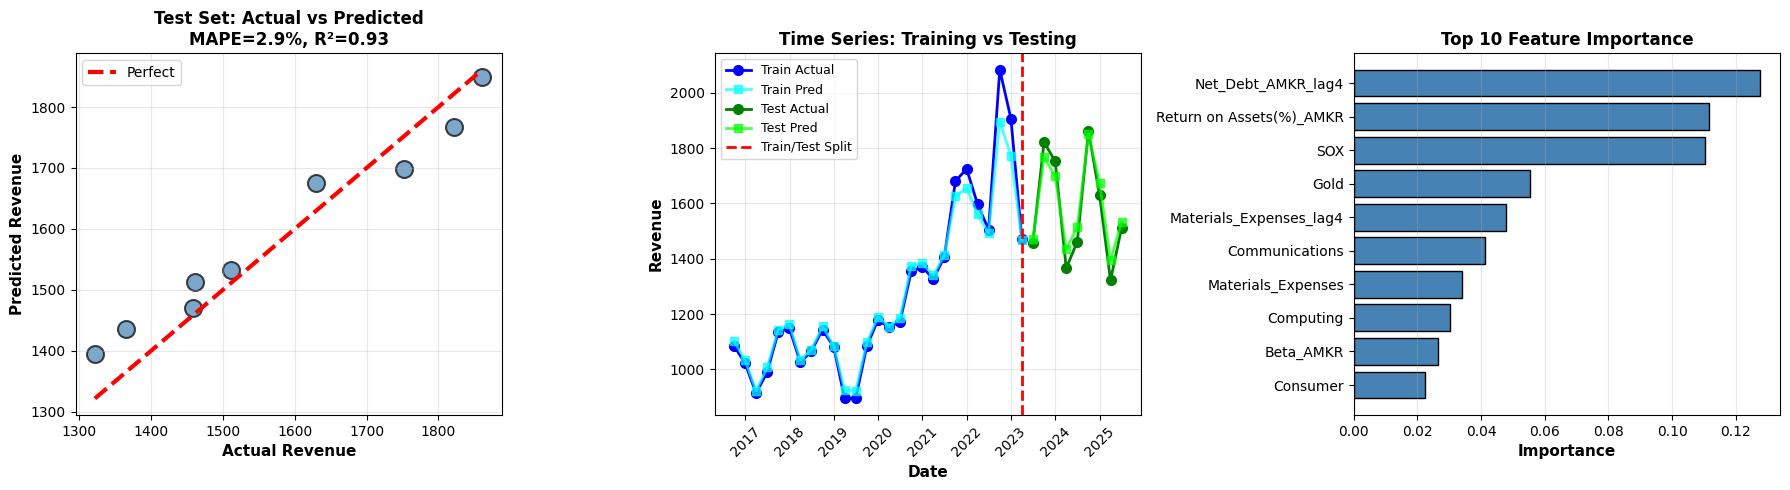

In [ ]:
# 6. MODEL EVALUATION

print("\n" + "=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train.values - y_train_pred) / y_train.values)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test.values - y_test_pred) / y_test.values)) * 100

if len(y_test) > 1:
    actual_direction = np.sign(np.diff(y_test.values))
    pred_direction = np.sign(np.diff(y_test_pred))
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100
else:
    directional_accuracy = None

print("\nTraining Set:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  R²:   {train_r2:.4f}")

print("\nTest Set:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R²:   {test_r2:.4f}")
if directional_accuracy is not None:
    print(f"  Directional Accuracy: {directional_accuracy:.1f}%")

print("\nIndividual Model Performance (Test MAE):")
print(f"  Ridge:      {mean_absolute_error(y_test, y_test_pred_ridge):.2f}")
print(f"  Lasso:      {mean_absolute_error(y_test, y_test_pred_lasso):.2f}")
print(f"  ElasticNet: {mean_absolute_error(y_test, y_test_pred_elastic):.2f}")
print(f"  XGBoost:    {mean_absolute_error(y_test, y_test_pred_xgb):.2f}")
print(f"  Ensemble:   {test_mae:.2f}")

# Diagnostic plots
fig_diag, axes_diag = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
ax1 = axes_diag[0]
ax1.scatter(
    y_test,
    y_test_pred,
    alpha=0.7,
    s=150,
    edgecolors='black',
    linewidths=1.5,
    color='steelblue',
)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect')
ax1.set_xlabel('Actual Revenue', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Revenue', fontsize=11, fontweight='bold')
ax1.set_title(
    f'Test Set: Actual vs Predicted\nMAPE={test_mape:.1f}%, R²={test_r2:.2f}',
    fontsize=12,
    fontweight='bold',
)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Time series comparison
ax2 = axes_diag[1]
all_dates = df_clean['Date']
ax2.plot(
    all_dates[:train_size],
    y_train,
    'o-',
    label='Train Actual',
    linewidth=2,
    markersize=7,
    color='blue',
)
ax2.plot(
    all_dates[:train_size],
    y_train_pred,
    's-',
    label='Train Pred',
    linewidth=2,
    markersize=6,
    color='cyan',
    alpha=0.7,
)
ax2.plot(
    all_dates[train_size:],
    y_test,
    'o-',
    label='Test Actual',
    linewidth=2,
    markersize=7,
    color='green',
)
ax2.plot(
    all_dates[train_size:],
    y_test_pred,
    's-',
    label='Test Pred',
    linewidth=2,
    markersize=6,
    color='lime',
    alpha=0.7,
)
ax2.axvline(
    x=all_dates.iloc[train_size - 1],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Train/Test Split',
)
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Revenue', fontsize=11, fontweight='bold')
ax2.set_title('Time Series: Training vs Testing', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, loc='best')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Feature importance (from XGBoost without variables related to the revenue)
ax3 = axes_diag[2]
feature_importance = pd.DataFrame(
    {'Feature': feature_cols, 'Importance': xgb_model.feature_importances_}
)

# Exclude features that contain the word 'Rev'
feature_importance = feature_importance[
    ~feature_importance['Feature'].str.contains('Rev', case=False)
]

# Sort and select top 10
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

ax3.barh(
    range(len(feature_importance)),
    feature_importance['Importance'],
    color='steelblue',
    edgecolor='black',
    linewidth=1,
)
ax3.set_yticks(range(len(feature_importance)))
ax3.set_yticklabels(feature_importance['Feature'], fontsize=10)
ax3.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [ ]:
# 7. REVENUE FORECASTING (10 Quarters)

print("\n" + "=" * 60)
print("REVENUE FORECAST - NEXT 10 QUARTERS")
print("=" * 60)

n_forecast = 10

try:
    # SARIMAX for time-series component
    sarimax_model = SARIMAX(
        df_clean[target],
        order=(2, 0, 2),
        seasonal_order=(1, 0, 1, 4),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    sarimax_fit = sarimax_model.fit(disp=False, maxiter=300)
    sarimax_forecast = sarimax_fit.forecast(steps=n_forecast)
    sarimax_conf_int = sarimax_fit.get_forecast(steps=n_forecast).conf_int()
    print("CHECK: SARIMAX model fitted")

    historical_values = df_clean[target].values

    # Recursive ensemble forecast
    last_features = X.iloc[[-1]].copy()
    last_features_scaled = scaler.transform(last_features)
    ensemble_forecast = []
    recent_values = list(historical_values[-4:])

    for i in range(n_forecast):
        pred_ridge = ridge_model.predict(last_features_scaled)[0]
        pred_lasso = lasso_model.predict(last_features_scaled)[0]
        pred_elastic = elastic_model.predict(last_features_scaled)[0]
        pred_xgb = xgb_model.predict(last_features.values)[0]

        pred_avg = (pred_ridge + pred_lasso + pred_elastic + pred_xgb) / 4

        # Add growth momentum
        if len(recent_values) >= 2:
            recent_growth = (recent_values[-1] - recent_values[-2]) / recent_values[-2]
            momentum = recent_values[-1] * recent_growth * 0.3
            pred_avg += momentum

        ensemble_forecast.append(pred_avg)
        recent_values.append(pred_avg)

        # Update lag features
        if 'Rev_AMKR_lag1' in last_features.columns:
            last_features['Rev_AMKR_lag1'] = pred_avg
        if 'Rev_AMKR_lag4' in last_features.columns and i >= 3:
            last_features['Rev_AMKR_lag4'] = ensemble_forecast[i - 3]
        if 'Rev_AMKR_rolling_mean_4' in last_features.columns and len(ensemble_forecast) >= 3:
            last_features['Rev_AMKR_rolling_mean_4'] = np.mean(
                ensemble_forecast[max(0, i - 3) : i + 1]
            )

        last_features_scaled = scaler.transform(last_features)

    # Hybrid forecast: 60% SARIMAX + 40% ensemble
    hybrid_forecast = 0.6 * sarimax_forecast.values + 0.4 * np.array(ensemble_forecast)

    # Adjust confidence intervals to match hybrid forecast
    sarimax_lower = sarimax_conf_int.iloc[:, 0].values
    sarimax_upper = sarimax_conf_int.iloc[:, 1].values

    adjustment = hybrid_forecast - sarimax_forecast.values
    lower_bounds = sarimax_lower + adjustment
    upper_bounds = sarimax_upper + adjustment

    # Ensure forecast is within bounds (with 5% buffer)
    margin = (upper_bounds - lower_bounds) * 0.05
    lower_bounds = np.minimum(lower_bounds, hybrid_forecast - margin)
    upper_bounds = np.maximum(upper_bounds, hybrid_forecast + margin)

except Exception as e:
    print(f"WARNING: SARIMAX failed, using ensemble only")

    historical_values = df_clean[target].values

    last_features = X.iloc[[-1]].copy()
    last_features_scaled = scaler.transform(last_features)

    hybrid_forecast = []
    recent_values = list(historical_values[-4:])

    for i in range(n_forecast):
        pred_ridge = ridge_model.predict(last_features_scaled)[0]
        pred_lasso = lasso_model.predict(last_features_scaled)[0]
        pred_elastic = elastic_model.predict(last_features_scaled)[0]
        pred_xgb = xgb_model.predict(last_features.values)[0]

        pred_avg = (pred_ridge + pred_lasso + pred_elastic + pred_xgb) / 4

        if len(recent_values) >= 2:
            recent_growth = (recent_values[-1] - recent_values[-2]) / recent_values[-2]
            momentum = recent_values[-1] * recent_growth * 0.3
            pred_avg += momentum

        hybrid_forecast.append(pred_avg)
        recent_values.append(pred_avg)

        if 'Rev_AMKR_lag1' in last_features.columns:
            last_features['Rev_AMKR_lag1'] = pred_avg

        last_features_scaled = scaler.transform(last_features)

    hybrid_forecast = np.array(hybrid_forecast)
    historical_std = np.std(historical_values)

    # Confidence intervals centered on hybrid forecast
    uncertainty = historical_std * np.sqrt(np.arange(1, n_forecast + 1))
    lower_bounds = hybrid_forecast - 1.96 * uncertainty
    upper_bounds = hybrid_forecast + 1.96 * uncertainty

# Create forecast dates (quarterly)
last_date = df_clean['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq='Q')[1:]


REVENUE FORECAST - NEXT 10 QUARTERS
CHECK: SARIMAX model fitted


/tmp/ipython-input-1018279394.py:118: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq='Q')[1:]


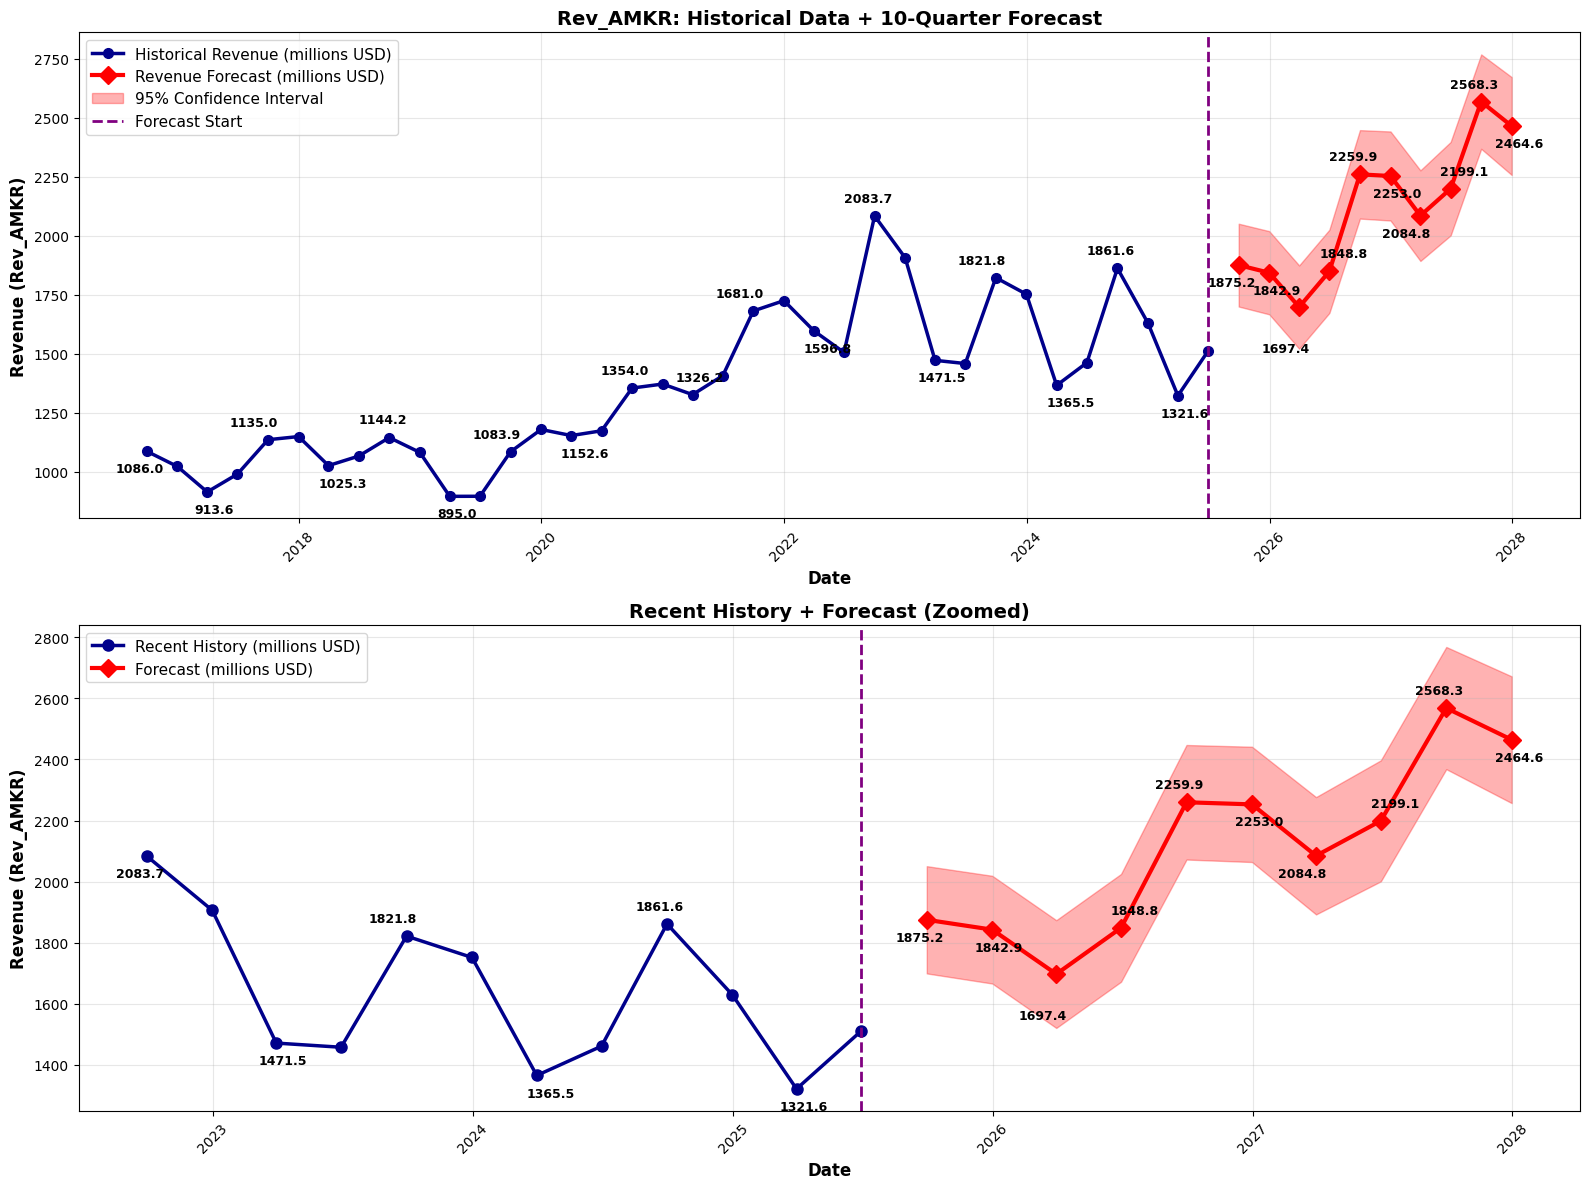

In [ ]:
#8. VISUALIZATION
from itertools import cycle

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

#function
def add_labels_with_skip(ax, x, y, skip_every=2, offset_points=8, special_indices=None):
    """
    Add labels to a line plot, skipping some points and optionally repositioning special indices.

    special_indices: dict {index: custom_offset_points}
    """
    x = np.array(x)
    y = np.array(y)

    if special_indices is None:
        special_indices = {}

    # horizontal offsets to avoid overlapping labels
    x_offsets = cycle([-5, 5, -10, 10])

    for i in range(len(x)):
        if skip_every is not None and (i % skip_every != 0):
            continue

        # Determine slope direction safely
        if i == 0:
            slope = y[i+1] - y[i]
        elif i == len(y)-1:
            slope = y[i] - y[i-1]
        else:
            slope = (y[i+1] - y[i-1]) / 2

        # Default vertical offset
        vp = offset_points if slope > 0 else -offset_points

        # Override for special indices
        if i in special_indices:
            vp = special_indices[i]

        # small horizontal nudge
        dx = next(x_offsets)
        va = 'bottom' if vp > 0 else 'top'

        ax.annotate(
            f"{y[i]:.1f}",
            xy=(x[i], y[i]),
            xytext=(dx, vp),
            textcoords="offset points",
            ha='center',
            va=va,
            fontsize=9,
            fontweight='bold'
        )

# Plot 1: Full history + forecast

ax1 = axes[0]
ax1.plot(df_clean['Date'], df_clean[target], 'o-', label='Historical Revenue (millions USD)',
         linewidth=2.5, markersize=7, color='darkblue')
ax1.plot(forecast_dates, hybrid_forecast, 'D-', label='Revenue Forecast (millions USD)',
         linewidth=3, markersize=9, color='red')
ax1.fill_between(forecast_dates, lower_bounds, upper_bounds, alpha=0.3,
                 color='red', label='95% Confidence Interval')
ax1.axvline(x=df_clean['Date'].iloc[-1], color='purple', linestyle='--',
            linewidth=2, label='Forecast Start')

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Revenue (Rev_AMKR)', fontsize=12, fontweight='bold')
ax1.set_title('Rev_AMKR: Historical Data + 10-Quarter Forecast',
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add labels
# Historical labels
add_labels_with_skip(ax1, df_clean['Date'], df_clean[target], skip_every=2)
# Forecast labels, move third label downward (-25 points)
add_labels_with_skip(ax1, forecast_dates, hybrid_forecast, skip_every=None, special_indices={2: -25})


# Plot 2: Recent history + forecast (zoomed)

ax2 = axes[1]
recent_n = min(12, len(df_clean))
recent_dates = df_clean['Date'].iloc[-recent_n:]
recent_values = df_clean[target].iloc[-recent_n:]

ax2.plot(recent_dates, recent_values, 'o-', label='Recent History (millions USD)',
         linewidth=2.5, markersize=8, color='darkblue')
ax2.plot(forecast_dates, hybrid_forecast, 'D-', label='Forecast (millions USD)',
         linewidth=3, markersize=9, color='red')
ax2.fill_between(forecast_dates, lower_bounds, upper_bounds, alpha=0.3, color='red')
ax2.axvline(x=df_clean['Date'].iloc[-1], color='purple', linestyle='--', linewidth=2)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Revenue (Rev_AMKR)', fontsize=12, fontweight='bold')
ax2.set_title('Recent History + Forecast (Zoomed)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Add labels
# Historical labels
add_labels_with_skip(ax2, recent_dates, recent_values, skip_every=2)
# Forecast labels, move third label downward (-25 points)
add_labels_with_skip(ax2, forecast_dates, hybrid_forecast, skip_every=None, special_indices={2: -25})

plt.tight_layout()
plt.show()

In [ ]:
# 9. FORECAST SUMMARY


forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Revenue': hybrid_forecast,
    'Lower_Bound_95%': lower_bounds,
    'Upper_Bound_95%': upper_bounds,
    'Quarter': [d.quarter for d in forecast_dates],
    'Year': [d.year for d in forecast_dates]
})

print("\n" + "="*60)
print("10-QUARTER REVENUE FORECAST")
print("="*60)
print(forecast_df.to_string(index=False))

# Calculate forecast growth rates
forecast_qoq_growth = np.diff(hybrid_forecast) / hybrid_forecast[:-1] * 100
total_growth = (hybrid_forecast[-1] - hybrid_forecast[0]) / hybrid_forecast[0] * 100

print(f"\nForecast Statistics:")
print(f"  Starting forecast: ${hybrid_forecast[0]:,.2f}")
print(f"  Ending forecast:   ${hybrid_forecast[-1]:,.2f}")
print(f"  Total growth:      {total_growth:.2f}%")
print(f"  Average QoQ growth: {np.mean(forecast_qoq_growth):.2f}%")
print(f"  Min forecast:      ${np.min(hybrid_forecast):,.2f}")
print(f"  Max forecast:      ${np.max(hybrid_forecast):,.2f}")

# Compare with historical averages
historical_avg = df_clean[target].mean()
forecast_avg = np.mean(hybrid_forecast)
print(f"\nComparison:")
print(f"  Historical average revenue: ${historical_avg:,.2f}")
print(f"  Forecast average revenue:   ${forecast_avg:,.2f}")
print(f"  Difference: {((forecast_avg - historical_avg) / historical_avg * 100):.2f}%")

# Quarterly breakdown
print(f"\nQuarterly Forecast Breakdown:")
for i, (date, rev) in enumerate(zip(forecast_dates, hybrid_forecast), 1):
    qtr = date.quarter
    year = date.year
    if i == 1:
        growth = "N/A (baseline)"
    else:
        growth_rate = (hybrid_forecast[i-1] - hybrid_forecast[i-2]) / hybrid_forecast[i-2] * 100
        growth = f"{growth_rate:+.2f}%"
    print(f"  {year}-Q{qtr}: ${rev:,.2f}  (Growth: {growth})")



10-QUARTER REVENUE FORECAST
      Date  Forecasted_Revenue  Lower_Bound_95%  Upper_Bound_95%  Quarter  Year
2025-09-30         1875.169746      1699.599531      2050.739961        3  2025
2025-12-31         1842.881961      1666.558002      2019.205921        4  2025
2026-03-31         1697.448442      1521.027190      1873.869693        1  2026
2026-06-30         1848.768498      1672.307644      2025.229353        2  2026
2026-09-30         2259.927541      2072.432117      2447.422965        3  2026
2026-12-31         2253.030225      2064.309260      2441.751190        4  2026
2027-03-31         2084.814163      1892.753940      2276.874386        1  2027
2027-06-30         2199.085633      2000.993176      2397.178090        2  2027
2027-09-30         2568.340791      2368.323227      2768.358354        3  2027
2027-12-31         2464.582688      2257.175698      2671.989678        4  2027

Forecast Statistics:
  Starting forecast: $1,875.17
  Ending forecast:   $2,464.58
  Total